In [ ]:
import numpy as np 
import pandas as pd 
import datetime
from pylab import rcParams
import matplotlib.pyplot as plt
import warnings
import itertools
import statsmodels.api as sm
from pathlib import Path
import yaml
import os



from sklearn.metrics import mean_absolute_error
import seaborn as sns
# sns.set_context("paper", font_scale=1)
sns.set_style('white')

from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model 
from tensorflow.keras.layers import (
    Dense, 
    Dropout, 
    LSTM, 
    TimeDistributed, 
    RepeatVector, 
    BatchNormalization, 
    dot, concatenate, 
    Input, 
    Activation
    )
from tensorflow.keras.callbacks import (
    ReduceLROnPlateau, 
    EarlyStopping, 
    ModelCheckpoint, 
    TensorBoard
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
data = pd.read_csv("data.csv", sep=";")

data = data.drop(["trades", "volume"], axis=1)

data.set_index("date", inplace=True)

In [ ]:
def to_supervised(train, n_input, n_out=7):
	# flatten data
# 	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(train)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end <= len(train):
			X.append(train[in_start:in_end, :])
			y.append(train[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return np.array(X), np.array(y)

In [ ]:
def sin_transform(values):
    return np.sin(2*np.pi*values/len(set(values)))

def cos_transform(values):
    return np.cos(2*np.pi*values/len(set(values)))

In [ ]:
data = data.drop(['year', 'is_month_end', 'is_month_start'], axis=1)

In [ ]:
train, test = data[:"2020-04-01"], data["2020-04-01":]

In [ ]:
temporal = ['day_of_week', 'day_of_year', 'day_of_month', 'month', 'week']
test_or = test.copy()
train_or = train.copy()
scls = {}
for col in train:
    if col in temporal:
        train[col] = sin_transform(train[col])
        test[col] = sin_transform(test[col])
    else:
        scl = MinMaxScaler()
        train[col] = scl.fit_transform(np.reshape(np.array(train[col].values), (-1, 1)))
        scls[col] = scl
        test[col] = scl.transform(np.reshape(np.array(test[col].values), (-1, 1)))

In [ ]:
train = train.to_numpy()
test = test.to_numpy()

In [ ]:
x, y = to_supervised(train, 60, 20)
test_x, test_y = to_supervised(test, 60, 20)

In [ ]:
def build_model(train, n_input, n_out):
  n_hidden = 50
  epc = 200
  bs = 8
  train_x, train_y = to_supervised(train, n_input, n_out)
  n_timesteps, n_features, n_outputs = \
    train_x.shape[1], train_x.shape[2], train_y.shape[1]
  input_train = Input(shape=(n_timesteps, n_features))
  output_train = Input(shape=(n_outputs, 1))

  encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
    n_hidden, activation='tanh', dropout=0.2, recurrent_dropout=0.0, 
    recurrent_activation="sigmoid", return_state=True, return_sequences=True,
    # kernel_regularizer="l2" 
    )(input_train)

  encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h) 
  encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)
  decoder_input = RepeatVector(n_outputs)(encoder_last_h) 
  decoder_stack_h = LSTM(n_hidden, activation='tanh', dropout=0.2, 
               recurrent_dropout=0.0,
               return_state=False, return_sequences=True, 
               recurrent_activation="sigmoid",
              #  kernel_regularizer="l2"
               )(
    decoder_input, initial_state=[encoder_last_h, encoder_last_c])
               
  attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
  attention = Activation('softmax')(attention)
  context = dot([attention, encoder_stack_h], axes=[2,1])
  context = BatchNormalization(momentum=0.6)(context)
  decoder_combined_context = concatenate([context, decoder_stack_h])
  out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)
  
  model = Model(inputs=input_train, outputs=out)
  opt = Adam(lr=0.0005, clipnorm=1)
  model.compile(loss='mean_squared_error', optimizer=opt,  
                metrics=['mape', 'mae'])
  print(model.summary())

  es = EarlyStopping(monitor='val_loss', mode='min', patience=50, 
                     restore_best_weights=True)
  lr = ReduceLROnPlateau(monitor="val_loss", patience=10)
  history = model.fit(train_x, train_y, validation_split=0.2, 
                    epochs=epc, verbose=1, callbacks=[es, lr], 
                    batch_size=bs) 
  return model, history

In [ ]:
model, history = build_model(train, 60, 20)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 60, 11)]     0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 60, 50), (No 12400       input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 50)           200         lstm_2[0][1]                     
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 20, 50)       0           batch_normalization_3[0][0]      
____________________________________________________________________________________________

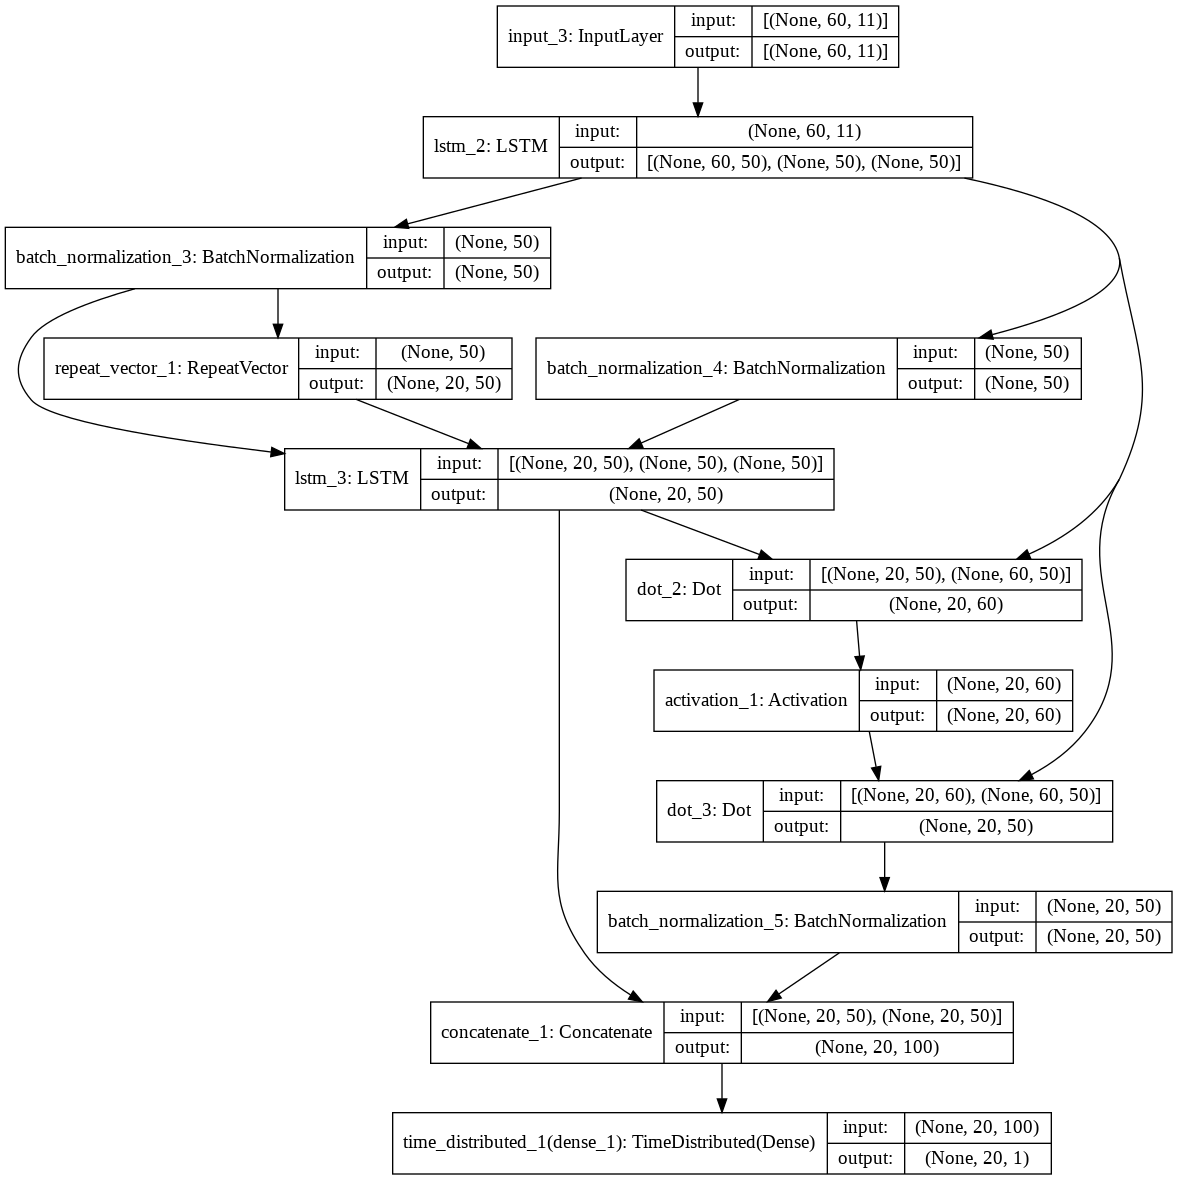

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

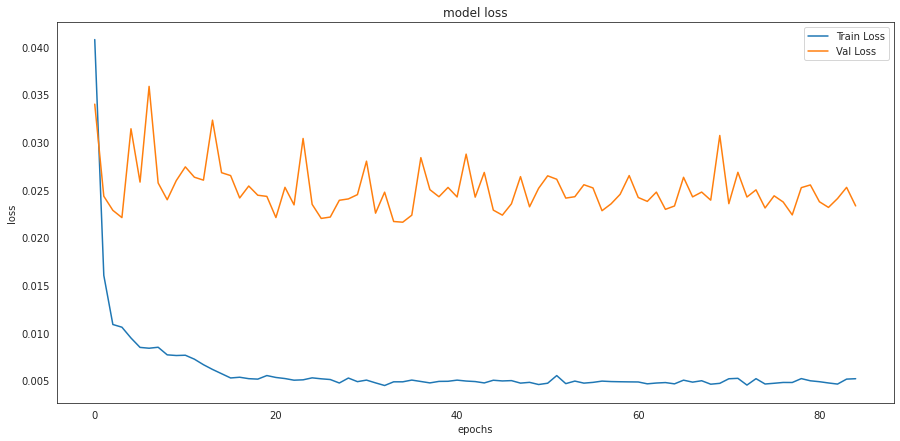

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('model loss')
# plt.gca().set_ylim(0,0.4)
# plt.set_ylim(0,1)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

In [ ]:
min(history.history["val_loss"])

0.021596623584628105

In [ ]:
test_x.shape

(262, 60, 11)

In [ ]:
test[60:80, 0]

array([0.42692835, 0.41664029, 0.426348  , 0.42502902, 0.43500053,
       0.43716366, 0.42877493, 0.44924554, 0.40635222, 0.41015089,
       0.41431888, 0.41115332, 0.41083676, 0.41732616, 0.4232352 ,
       0.42692835, 0.42481798, 0.4306215 , 0.45504907, 0.46554817])

In [ ]:
test_y[0]

array([0.42692835, 0.41664029, 0.426348  , 0.42502902, 0.43500053,
       0.43716366, 0.42877493, 0.44924554, 0.40635222, 0.41015089,
       0.41431888, 0.41115332, 0.41083676, 0.41732616, 0.4232352 ,
       0.42692835, 0.42481798, 0.4306215 , 0.45504907, 0.46554817])

In [ ]:
test_x[0, :, 0]

array([-0.25201629,  0.03191938,  0.04310436,  0.04658647,  0.04526749,
        0.05703282,  0.10683761,  0.11454047,  0.12308747,  0.11184974,
        0.15870001,  0.09797404,  0.10356653,  0.09465021,  0.08404558,
        0.07718687,  0.07549858,  0.07576237,  0.06215047,  0.076501  ,
        0.0779255 ,  0.08277936,  0.08552284,  0.09939854,  0.10694313,
        0.1178643 ,  0.11818086,  0.11248285,  0.1272027 ,  0.13954838,
        0.16587528,  0.19600084,  0.24596391,  0.26849214,  0.24158489,
        0.24949879,  0.24522528,  0.24886567,  0.24886567,  0.27529809,
        0.29471352,  0.34773663,  0.36419753,  0.39020787,  0.41996412,
        0.44270339,  0.44391685,  0.44006542,  0.37970877,  0.3663079 ,
        0.35000528,  0.36767965,  0.37047589,  0.38445711,  0.37838979,
        0.38630368,  0.37791495,  0.36841828,  0.37216419,  0.40466392])

In [ ]:
predictions = model.predict(test_x)

In [ ]:
predictions.shape

(262, 20, 1)

In [ ]:
yhat=predictions[2, :, :].flatten()

In [ ]:
yhat_desc = scls["index_value"].inverse_transform(yhat.reshape(1,-1)).flatten()

In [ ]:
y_true = test_or.iloc[62:82].index_value

In [ ]:
yh = []
for i in range(predictions.shape[0]-1, 0, -1):
  if i == predictions.shape[0]-1:
    f = predictions[i, :, :].flatten()
    for y in f:
      yh.append(y)
  else:
    yh.append(predictions[i, 0, :].flatten()[0])
yh.reverse()

In [ ]:
yhat_desc = scls["index_value"].inverse_transform(np.array(yh).reshape(1,-1)).flatten()

In [ ]:
plot_df = pd.DataFrame(data={"ytrue":test_or.iloc[60:-1, 0].values, "yhat":yhat_desc}, index=test_or.iloc[60:-1, 0].index)

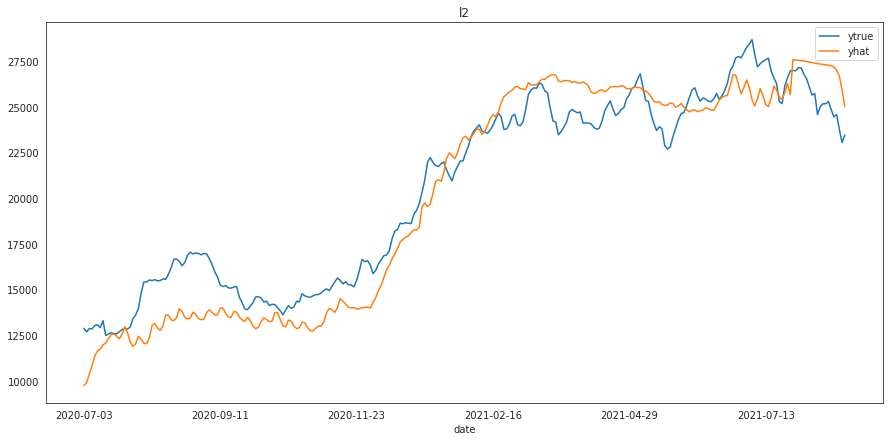

In [ ]:
plot_df.plot(figsize=(15, 7), title="l2")

In [ ]:
plot_df.to_csv("pred.csv")

In [ ]:
model.save("best_model.hdf5")